# Fake and Real News Classifier
This is an NLP based problem 

## Importing Libraries 

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import time


## Dataset Handling 

### Loading Dataset

In [33]:
fake_news = pd.read_csv('datasets/fake-true-news/Fake.csv')
true_news = pd.read_csv('datasets/fake-true-news/True.csv')

In [36]:
print("Columns in the dataset", fake_news.columns)

Columns in the dataset Index(['title', 'text', 'subject', 'date'], dtype='object')


In [35]:
print("Fake News Values: \n")
fake_news.head()

Fake News Values: 



,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [37]:
print("True News Samples: \n")
true_news.head()

True News Samples: 



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [38]:
## Size of Samples
print("Number of True Samples: ", true_news.count())
print("Number of Fake Samples: ", fake_news.count())

Number of True Samples:  title      21417
text       21417
subject    21417
date       21417
dtype: int64
Number of Fake Samples:  title      23481
text       23481
subject    23481
date       23481
dtype: int64


### Data Preprocessing 

#### Handling Missing Values

In [39]:
## Checking missing values
fake_missing_values = fake_news.isnull().sum()
true_missing_values = true_news.isnull().sum()

print("Missing Values in Fake Data: ", fake_missing_values)
print("Missing Values in True Data: ", true_missing_values)



Missing Values in Fake Data:  title      0
text       0
subject    0
date       0
dtype: int64
Missing Values in True Data:  title      0
text       0
subject    0
date       0
dtype: int64


### Detecting Outliers

In [40]:
fake_news['label'] = 1
true_news['label'] = 0
combined_dataset = pd.concat([fake_news, true_news])
combined_dataset.head()


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [41]:
combined_dataset['text_length'] = combined_dataset['text'].apply(lambda x: len(str(x)))
combined_dataset['word_count'] = combined_dataset['text'].apply(lambda x: len(str(x).split()))


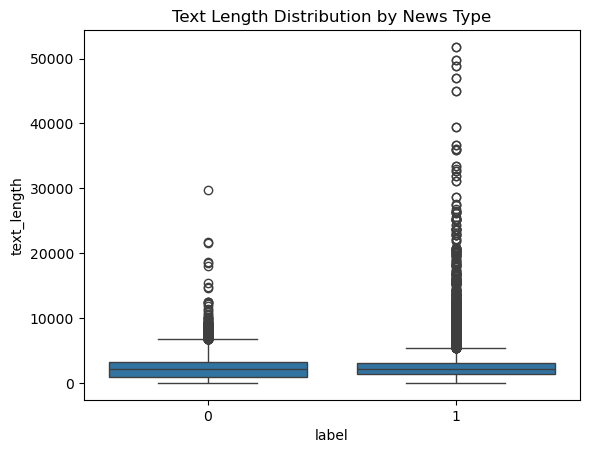

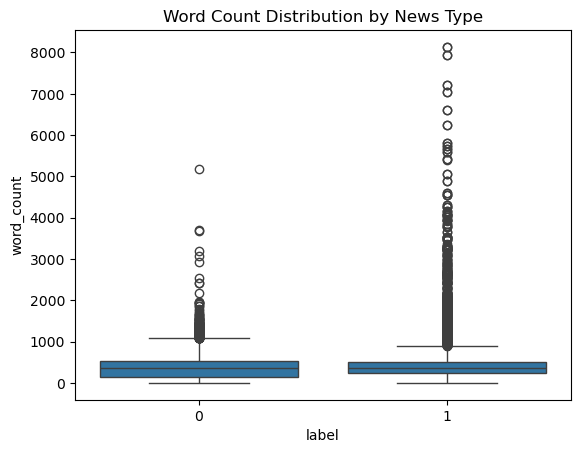

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='label', y='text_length', data=combined_dataset)
plt.title('Text Length Distribution by News Type')
plt.show()

sns.boxplot(x='label', y='word_count', data=combined_dataset)
plt.title('Word Count Distribution by News Type')
plt.show()


### Preprocessing Text

In [43]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

In [44]:
def preprocess_with_spacy_pipe(df, column):  
    processed_texts = []

    for doc in tqdm(nlp.pipe(df[column], batch_size=1000), total=len(df), desc="Preprocessing"):
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        processed_texts.append(" ".join(tokens))
    
    return processed_texts 


In [45]:
combined_dataset['preprocessed_text'] = preprocess_with_spacy_pipe(combined_dataset, 'text')


Preprocessing: 100%|██████████| 44898/44898 [25:40<00:00, 29.14it/s]   


In [37]:
print("Total columns after preprocessing:\n",combined_dataset.columns)
combined_dataset['preprocessed_text']

Total columns after preprocessing:
 Index(['title', 'text', 'subject', 'date', 'label', 'text_length',
       'word_count', 'preprocessed_text'],
      dtype='object')


0        Donald Trump couldn t wish Americans Happy New...
1        House Intelligence Committee Chairman Devin Nu...
2        Friday reveal Milwaukee Sheriff David Clarke c...
3        Christmas day Donald Trump announce   work   f...
4        Pope Francis annual Christmas Day message rebu...
                               ...                        
21412    BRUSSELS Reuters NATO ally Tuesday welcome Pre...
21413    LONDON Reuters LexisNexis provider legal regul...
21414    MINSK Reuters shadow disuse Soviet era factory...
21415    MOSCOW Reuters Vatican Secretary State Cardina...
21416    JAKARTA Reuters Indonesia buy 11 Sukhoi fighte...
Name: preprocessed_text, Length: 44898, dtype: object

### Train Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_dataset.preprocessed_text, 
    combined_dataset.label,
    test_size=0.2, 
    random_state=42,
    stratify=combined_dataset.label
)
print("Number of Training Samples: ", y_train.count())
print("Number of Testing Samples: ", y_test.count())


Number of Training Samples:  35918
Number of Testing Samples:  8980


## Training

### Pipeline Creation

In [48]:
clf = Pipeline([
    ('vectorizer_n_grams', CountVectorizer(ngram_range=(1, 3))),
    ('random_forest', RandomForestClassifier(n_jobs=-1))  # Use all available cores
])

In [50]:
start_time = time.perf_counter() 
clf.fit(X_train, y_train) 
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Total training time for Random Forest {elapsed_time}")

Total training time for Random Forest 1065.1568566729998


## Testing

In [53]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [62]:
text = '''In a surprising turn of events, the beloved local bakery, "Breads & Beyond," has unveiled a new bread recipe that has taken the community by storm. The bakery's owner, Martha Jenkins, announced the launch of her "Super Grain Bread" during a packed press conference on Monday morning.
According to Jenkins, the new recipe combines ancient grains like spelt, quinoa, and amaranth with a secret blend of herbs and spices that she claims will revolutionize breakfast tables across the nation. "We wanted to create something that not only tastes incredible but also packs a nutritional punch," Jenkins stated. "This bread is high in protein, fiber, and essential vitamins."
The announcement was met with enthusiastic applause from local residents and health enthusiasts alike. Many were eager to sample the new bread, which will be available starting next week at the bakery's downtown location.
Local nutritionist Dr. Emily Carter praised the initiative, saying, "This could be a game-changer for those looking to incorporate healthier options into their diets. It's great to see local businesses innovating in such a positive way."
In addition to its health benefits, "Super Grain Bread" is also environmentally friendly. Jenkins revealed that all ingredients are sourced from local farms and that the bakery has implemented sustainable practices in its production process.
To celebrate the launch, Breads & Beyond will host a community tasting event on Saturday, where residents can sample the new bread alongside various toppings and spreads. The first 100 attendees will receive a free loaf to take home.
As word spreads about this exciting new product, it seems that Springfield's culinary scene is poised for an exciting transformation—one slice at a time. Feel free to ask if you need anything else or if you'd like a different type of fictional news!'''

y_pred = clf.predict([text])
print(y_pred)

[1]


In [63]:
text = '''LOS ANGELES − The death toll from a devastating series of fires in Los Angeles County rose to 16, officials announced, as air crews used fire retardant and water to battle the Palisades Fire that threatened homes even closer to the heart of the city on Saturday.
On the fifth day since the Palisades Fire began, the largest of four active wildfires in Los Angeles County was encroaching on a major Southern California artery as the flames expanded to the northeast and officials warned of more extreme fire weather conditions this weekend. Meanwhile, 11 deaths had been attributed to the Eaton Fire, which had scorched more than 14,000 acres and was 15% contained Saturday evening.
Fire retardant, in a distinctive hot pink shower, blanketed houses, streets and fire trucks in Mandeville Canyon, tucked in the Santa Monica Mountains, not far from the 405 freeway. Several other aircraft gushed water throughout the hillside neighborhood as the encroaching fire neared an electric tower.
'''

y_pred = clf.predict([text])
print(y_pred)

[1]
